AUTHOR: Rafael Stankiewicz

# Imports

In [46]:
import pandas as pd
import numpy as np
import pickle
import random
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import pylab
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, max_error, median_absolute_error, confusion_matrix 
from sklearn.inspection import PartialDependenceDisplay
from tensorflow.keras.callbacks import ModelCheckpoint

import keras.backend as K
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras import metrics
from keras.models import load_model

import tensorflow as tf

params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

cp = sns.color_palette("coolwarm", 12) + sns.color_palette("coolwarm_r", 12)
my_cmap = ListedColormap(sns.color_palette(cp).as_hex())

In [24]:
!pip install colab-env --upgrade

import os
import colab_env

#Rafael's Data Fetcher 
!wget https://raw.githubusercontent.com/rafaelstankiewicz/ML-for-Air-Quality-Prediction/main/data_fetcher.py
!wget https://raw.githubusercontent.com/rafaelstankiewicz/ML-for-Air-Quality-Prediction/main/preprocessing.py

os.environ['EMAIL'] = ""
os.environ['KEY'] = ""

from data_fetcher import DataFetcher

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2022-11-21 07:21:31--  https://raw.githubusercontent.com/rafaelstankiewicz/ML-for-Air-Quality-Prediction/main/data_fetcher.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29770 (29K) [text/plain]
Saving to: ‘data_fetcher.py.1’

data_fetcher.py.1   100%[===================>]  29.07K  --.-KB/s    in 0.001s  

2022-11-21 07:21:32 (28.6 MB/s) - ‘data_fetcher.py.1’ saved [29770/29770]

--2022-11-21 07:21:32--  https://raw.githubusercontent.com/rafaelstankiewicz/ML-for-Air-Quality-Prediction/main/preprocessing.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubuserc

# Getting Data!!

We're using Simi Valley-Cochran Street! It's in the West climate zone in california

state_code = 06

site_number = 2002

county_code = 111

Time range is the start of 2011 to end of 2017

In [25]:
datafetcher = DataFetcher()

In [26]:
SVC_df = datafetcher.create_dataset(20110101, 20171231, site='2002', county='111', state='06')

No data for Carbon monoxide
There is hourly data for PM2.5 - Local Conditions starting in the year 2013
No data for Ultraviolet radiation
No data for Barometric pressure


In [27]:
# pickle_out = open("/content/gdrive/Shared drives/FICUS_Lab/Data/dills_and_pickles/poster_Su22/SVC_df.pickle","wb")
# pickle.dump(SVC_df, pickle_out)
# pickle_out.close()

pickle_in = open("/content/gdrive/My Drive/ML Research/Training Time vs. Model Performance/SimiValleyDF_2011_2017.pickle","rb")
SVC_df = pickle.load(pickle_in)

In [28]:
SVC_df

,Carbon monoxide,Nitrogen dioxide (NO2),Ozone,PM2.5 - Local Conditions,Wind Direction - Resultant,Wind Speed - Resultant,Outdoor Temperature,Relative Humidity,Solar radiation,Carbon monoxide - qualifier,Nitrogen dioxide (NO2) - qualifier,Ozone - qualifier,PM2.5 - Local Conditions - qualifier,Wind Direction - Resultant - qualifier,Wind Speed - Resultant - qualifier,Outdoor Temperature - qualifier,Relative Humidity - qualifier,Solar radiation - qualifier
datetime,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,NaN,23.0,0.004,NaN,78.0,1.4,41.0,57.0,0.0,None,None,None,None,None,None,None,None,None
2011-01-01 01:00:00,NaN,NaN,NaN,NaN,108.0,1.6,40.0,58.0,0.0,None,BA - Maintenance/Routine Repairs.,BA - Maintenance/Routine Repairs.,None,None,None,None,None,None
2011-01-01 02:00:00,NaN,16.0,0.011,NaN,85.0,1.9,42.0,52.0,0.0,None,None,None,None,None,None,None,None,None
2011-01-01 03:00:00,NaN,14.0,0.010,NaN,129.0,1.2,42.0,54.0,0.0,None,None,None,None,None,None,None,None,None
2011-01-01 04:00:00,NaN,22.0,0.002,NaN,89.0,1.4,41.0,60.0,0.0,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 19:00:00,NaN,14.0,0.026,44.5,184.0,0.0,52.0,84.0,0.0,None,None,None,None,None,None,None,None,None
2017-12-31 20:00:00,NaN,21.0,0.012,42.5,92.0,1.2,50.0,85.0,0.0,None,None,None,None,None,None,None,None,None
2017-12-31 21:00:00,NaN,23.0,0.007,49.5,85.0,1.4,49.0,85.0,0.0,None,None,None,None,None,None,None,None,None


Now we want to make sure we're only training with the variables that we have for sure:

- NO2
- Ozone
- Wind Direction
- Wind Speed
- Outdoor Temperature
- Relative Humidity
- Solar Radiation

No Barometric Pressure in the df, and we don't want PM2.5

Therefore we're going to drop all our extra columns!!!

In [29]:
# first, dropping all qualifiers
SVC_df = SVC_df.drop(SVC_df.columns[[9,10,11,12,13,14,15,16,17]], axis=1)
SVC_df


,Carbon monoxide,Nitrogen dioxide (NO2),Ozone,PM2.5 - Local Conditions,Wind Direction - Resultant,Wind Speed - Resultant,Outdoor Temperature,Relative Humidity,Solar radiation
datetime,,,,,,,,,
2011-01-01 00:00:00,NaN,23.0,0.004,NaN,78.0,1.4,41.0,57.0,0.0
2011-01-01 01:00:00,NaN,NaN,NaN,NaN,108.0,1.6,40.0,58.0,0.0
2011-01-01 02:00:00,NaN,16.0,0.011,NaN,85.0,1.9,42.0,52.0,0.0
2011-01-01 03:00:00,NaN,14.0,0.010,NaN,129.0,1.2,42.0,54.0,0.0
2011-01-01 04:00:00,NaN,22.0,0.002,NaN,89.0,1.4,41.0,60.0,0.0
...,...,...,...,...,...,...,...,...,...
2017-12-31 19:00:00,NaN,14.0,0.026,44.5,184.0,0.0,52.0,84.0,0.0
2017-12-31 20:00:00,NaN,21.0,0.012,42.5,92.0,1.2,50.0,85.0,0.0
2017-12-31 21:00:00,NaN,23.0,0.007,49.5,85.0,1.4,49.0,85.0,0.0


In [30]:
# now to narrow down
SVC_df = SVC_df.drop('PM2.5 - Local Conditions', axis=1)
SVC_df = SVC_df.drop('Carbon monoxide', axis=1)
SVC_df

,Nitrogen dioxide (NO2),Ozone,Wind Direction - Resultant,Wind Speed - Resultant,Outdoor Temperature,Relative Humidity,Solar radiation
datetime,,,,,,,
2011-01-01 00:00:00,23.0,0.004,78.0,1.4,41.0,57.0,0.0
2011-01-01 01:00:00,NaN,NaN,108.0,1.6,40.0,58.0,0.0
2011-01-01 02:00:00,16.0,0.011,85.0,1.9,42.0,52.0,0.0
2011-01-01 03:00:00,14.0,0.010,129.0,1.2,42.0,54.0,0.0
2011-01-01 04:00:00,22.0,0.002,89.0,1.4,41.0,60.0,0.0
...,...,...,...,...,...,...,...
2017-12-31 19:00:00,14.0,0.026,184.0,0.0,52.0,84.0,0.0
2017-12-31 20:00:00,21.0,0.012,92.0,1.2,50.0,85.0,0.0
2017-12-31 21:00:00,23.0,0.007,85.0,1.4,49.0,85.0,0.0


# Now to split the data!!! 

We want to do 5 years training, 2 years testing 

In [31]:
SVC_df = SVC_df.interpolate()
SVC_df.isna().sum()

Nitrogen dioxide (NO2)        0
Ozone                         0
Wind Direction - Resultant    0
Wind Speed - Resultant        0
Outdoor Temperature           0
Relative Humidity             0
Solar radiation               0
dtype: int64

In [32]:
n_steps = 24
SVC_df_norm=(SVC_df-SVC_df.min())/(SVC_df.max()-SVC_df.min())

# switching the location of the columns
B = SVC_df_norm.filter(['Ozone']) # just ozone
A = SVC_df_norm.drop(['Ozone'], axis=1) # everything but ozone
C = pd.merge(A, B, left_index=True, right_index=True) # everything but ozone + just ozone
SVC_df_np = C.to_numpy() # now in numpy format 

In [33]:
def split_data(data_np, n_steps):
	"""
	Parameters:
		data_np: numpy version of the data 
		n_steps: steps fed to the LSTM????

	Returns
		X and Y np.arrays with the data split by the last value 
	"""
	X, y = list(), list() # making empty lists to store our X and y
	# for number of samples (ex: 43824)
	for i in range(len(data_np)):
		# kills loop if we are n_steps from the end of the total timesteps 
		end_ix = i + n_steps 
		if end_ix > len(data_np):
			break
    # this will reshape the data for input into the CNN
		# for data_x, appends times i to ix but without ozone
		# for data_np, appends last ozone 
		data_x, data_y = data_np[i:end_ix, :-1], data_np[end_ix-1, -1]
		X.append(data_x)
		y.append(data_y)
	return np.array(X), np.array(y)

In [34]:
X_for_CNN, y_for_CNN = split_data(SVC_df_np, n_steps)

Now we want a 5 year / 2 year split for train and test!

This means we want len//7 * 5 

In [35]:
print(len(SVC_df))
print(len(X_for_CNN))

61368
61345


So we want 

In [36]:
# takes first 3rd of data for test 
seventh = len(SVC_df)//7
X_train_for_CNN = X_for_CNN[:seventh*5]
y_train_for_CNN = y_for_CNN[:seventh*5]
X_test_for_CNN = X_for_CNN[seventh*5:]
y_test_for_CNN = y_for_CNN[seventh*5:]

In [37]:
pickle_out = open("/content/gdrive/My Drive/ML Research/Training Time vs. Model Performance/y_test_for_CNN.pickle","wb")
pickle.dump(y_test_for_CNN, pickle_out)
pickle_out.close()

# pickle_in = open("/content/gdrive/My Drive/ML Research/Training Time vs. Model Performance/lstm_simivalley_prediction.pickle","rb")
# y_pred_for_LSTM = pickle.load(pickle_in)

Let's check when the first date is real fast!

In [38]:
SVC_df[seventh*5:]

,Nitrogen dioxide (NO2),Ozone,Wind Direction - Resultant,Wind Speed - Resultant,Outdoor Temperature,Relative Humidity,Solar radiation
datetime,,,,,,,
2016-01-01 06:00:00,0.0,0.038,39.0,6.2,47.0,21.0,0.00
2016-01-01 07:00:00,0.0,0.038,38.0,7.8,47.0,21.0,0.05
2016-01-01 08:00:00,1.0,0.038,25.0,8.2,49.0,20.0,0.36
2016-01-01 09:00:00,1.0,0.038,17.0,8.9,50.0,19.0,0.60
2016-01-01 10:00:00,1.0,0.038,23.0,8.7,53.0,18.0,0.78
...,...,...,...,...,...,...,...
2017-12-31 19:00:00,14.0,0.026,184.0,0.0,52.0,84.0,0.00
2017-12-31 20:00:00,21.0,0.012,92.0,1.2,50.0,85.0,0.00
2017-12-31 21:00:00,23.0,0.007,85.0,1.4,49.0,85.0,0.00


In [39]:
# the timestamp is shifted by a day (when n_steps = 24) because of how I set up the windowing
date_time_test_CNN = C.index[seventh*5 + n_steps - 1:] 

In [40]:
pickle_out = open("/content/gdrive/My Drive/ML Research/Training Time vs. Model Performance/date_time_test_CNN.pickle","wb")
pickle.dump(date_time_test_CNN, pickle_out)
pickle_out.close()

## Validation Metrics

In [41]:
# Mean Absolute Error
def mae(y_test, y_pred):
  N = tf.cast(len(y_test), tf.float32)
  abs_pred_minus_test = K.abs(y_pred - y_test)

  MAE = K.sum(abs_pred_minus_test)/N
  return MAE

# Mean Absolute Bias
def mab(y_test, y_pred):
  N = tf.cast(len(y_test), tf.float32)
  pred_minus_test =y_pred, y_test

  MAB = K.sum(pred_minus_test)/N
  return MAB

# Normalized Mean Error
def nme(y_test, y_pred):
  N = tf.cast(len(y_test), tf.float32)
  abs_pred_minus_test = K.abs(y_pred - y_test)

  NME = K.sum(abs_pred_minus_test)/K.sum(y_pred)
  return NME

# Normalized Mean Bias
def nmb(y_test, y_pred):
  pred_minus_test = (y_pred - y_test)

  NMB = K.sum(pred_minus_test)/K.sum(y_pred)
  return NMB


  # Fractional Error
def fe(y_test, y_pred):
  pred_plus_test  = y_pred + y_test
  abs_pred_minus_test = K.abs(y_pred - y_test)

  FE = 2*K.sum(abs_pred_minus_test)/K.sum(pred_plus_test)
  return FE

# Fractional Bias
def fb(y_test, y_pred):
  pred_minus_test = y_pred - y_test
  pred_plus_test  = y_pred + y_test

  FB = 2* K.sum(pred_minus_test)/K.sum(pred_plus_test)
  return FB


# R - correlation coefficient
def R(y_test, y_pred):
  pred_var = y_pred - K.mean(y_pred)  
  test_var = y_test - K.mean(y_test) 
  PxT = pred_var*test_var
  pred_var2 = pred_var*pred_var
  test_var2 = test_var*test_var 
  R = K.sum(PxT)/K.sqrt(K.sum(pred_var2)*K.sum(test_var2))
  return R

# R - correlation coefficient
def one_minus_R2(y_test, y_pred):
  pred_var = y_pred - K.mean(y_pred)  
  test_var = y_test - K.mean(y_test) 
  PxT = pred_var*test_var
  pred_var2 = pred_var*pred_var
  test_var2 = test_var*test_var 
  R = K.sum(PxT)/K.sqrt(K.sum(pred_var2)*K.sum(test_var2))
  return 1-R*R

  # d - index of agreement
def d(y_test, y_pred):
  test_var = y_test - K.mean(y_test) 
  pred_minus_test = y_pred - y_test
  pred_minus_test2 = pred_minus_test*pred_minus_test
  pred_minus_testmean = y_pred - K.mean(y_test)  
  abs_PmTM_plus_abs_TmTM = K.abs(pred_minus_testmean) + K.abs(test_var)
  abs_PmTM_plus_abs_TmTM2 =abs_PmTM_plus_abs_TmTM*abs_PmTM_plus_abs_TmTM
  d = 1 - K.sum(pred_minus_test2)/K.sum(abs_PmTM_plus_abs_TmTM2)
  return d
def inv_d(y_test, y_pred):
  return 1/d(y_test, y_pred)

  # NMSE
def nmse(y_test, y_pred):
  pred_times_test = y_pred * y_test
  pred_minus_test = y_pred - y_test
  pred_minus_test2 = pred_minus_test*pred_minus_test
  NMSE = K.mean(pred_minus_test2)/K.mean(pred_times_test)
  return NMSE

# Actual model!!

In [53]:
model_lstm_4 = Sequential()
model_lstm_4.add(LSTM(8, input_shape=(n_steps, SVC_df.shape[1]-1)))
model_lstm_4.add(Dense(1))
model_lstm_4.compile(loss='mean_squared_error', optimizer='adam', metrics=[mae, mab, nme, nmb, nmse, fe, fb, R, d])
history4 = model_lstm_4.fit(X_train_for_CNN, y_train_for_CNN, epochs=20, validation_data=(X_test_for_CNN, y_test_for_CNN), verbose=2)

Epoch 1/20
1370/1370 - 11s - loss: 0.0113 - mae: 0.0755 - mab: 0.6221 - nme: -2.0242e-01 - nmb: 0.4153 - nmse: 0.1420 - fe: 0.2801 - fb: -6.4815e-02 - R: 0.8391 - d: 0.8870 - val_loss: 0.0050 - val_mae: 0.0549 - val_mab: 0.6434 - val_nme: 0.1766 - val_nmb: -2.5090e-03 - val_nmse: 0.0442 - val_fe: 0.1773 - val_fb: 0.0085 - val_R: 0.8968 - val_d: 0.8973 - 11s/epoch - 8ms/step
Epoch 2/20
1370/1370 - 8s - loss: 0.0049 - mae: 0.0542 - mab: 0.6304 - nme: 0.1729 - nmb: -7.3414e-04 - nmse: 0.0406 - fe: 0.1728 - fb: 3.0764e-04 - R: 0.9122 - d: 0.9484 - val_loss: 0.0042 - val_mae: 0.0498 - val_mab: 0.6367 - val_nme: 0.1628 - val_nmb: -2.1654e-02 - val_nmse: 0.0372 - val_fe: 0.1613 - val_fb: -1.1516e-02 - val_R: 0.9122 - val_d: 0.9091 - 8s/epoch - 6ms/step
Epoch 3/20
1370/1370 - 8s - loss: 0.0042 - mae: 0.0497 - mab: 0.6304 - nme: 0.1586 - nmb: -1.0424e-03 - nmse: 0.0346 - fe: 0.1586 - fb: 1.8298e-05 - R: 0.9258 - d: 0.9564 - val_loss: 0.0038 - val_mae: 0.0467 - val_mab: 0.6454 - val_nme: 0.1495 

In [54]:
pickle_out = open("/content/gdrive/My Drive/ML Research/Training Time vs. Model Performance/model_lstm_4.pickle","wb")
pickle.dump(model_lstm_4, pickle_out)
pickle_out.close()

In [ ]:
pickle_in = open("/content/gdrive/My Drive/ML Research/Training Time vs. Model Performance/model_lstm_4.pickle","rb")
model_lstm_4 = load_model("/content/gdrive/My Drive/ML Research/Training Time vs. Model Performance/model_lstm_4.pickle", custom_objects={'mae':mae,'mab':mab,'nme':nme,'nmb':nmb,'nmse':nmse,'fe':fe,'fb':fb,'R':R,'d':d}, compile=False)
model_lstm_4 = pickle.load(pickle_in)

## Train/Test Data Validation Metrics for Simi Valley



In [58]:
def plot_training_validation_specific_metrics(history4): 
    keys = list(history4.history.keys())
    num_plots = int(len(keys)/2)

    fig, ax = plt.subplots(4, 2, figsize=(15,25))
    ax[0,0].set_title('Loss')
    ax[0,0].plot(history4.epoch, history4.history[keys[0]], label="Train loss")
    ax[0,0].plot(history4.epoch, history4.history[keys[num_plots]], label="Validation loss")
    ax[2,1].set_ylabel("Loss")
    
    ax[0,1].set_title('Accuracy: R')
    ax[0,1].plot(history4.epoch, history4.history['R'], label='train')
    ax[0,1].plot(history4.epoch, history4.history['val_R'], label='test')
    ax[2,1].set_ylabel("R")
    
    ax[1,0].set_title('Accuracy: Normalized Mean Error')
    ax[1,0].plot(history4.epoch, history4.history['nme'], label='train')
    ax[1,0].plot(history4.epoch, history4.history['val_nme'], label='test')
    ax[2,1].set_ylabel("NME")

    ax[1,1].set_title('Accuracy: Normalized Mean Bias')
    ax[1,1].plot(history4.epoch, history4.history['nmb'], label='train')
    ax[1,1].plot(history4.epoch, history4.history['val_nmb'], label='test')
    ax[2,1].set_ylabel("NMB")

    ax[2,0].set_title('Accuracy: Mean Absolute Error')
    ax[2,0].plot(history4.epoch, history4.history['mae'], label='train')
    ax[2,0].plot(history4.epoch, history4.history['val_mae'], label='test')
    ax[2,1].set_ylabel("MAE")

    ax[2,1].set_title('Accuracy: Mean Absolute Bias')
    ax[2,1].plot(history4.epoch, history4.history['mab'], label='train')
    ax[2,1].plot(history4.epoch, history4.history['val_mab'], label='test')
    ax[2,1].set_ylabel("MAB")

    ax[3,0].set_title('Accuracy:d - index of agreement')
    ax[3,0].plot(history4.epoch, history4.history['d'], label='train')
    ax[3,0].plot(history4.epoch, history4.history['val_d'], label='test')
    ax[3,0].set_ylabel("d")
    ax[3,0].set_xlabel("Epoch number")

    ax[3,1].set_title('Accuracy: Normalized Mean Square Error')
    ax[3,1].plot(history4.epoch, history4.history['nmse'], label='train')
    ax[3,1].plot(history4.epoch, history4.history['val_nmse'], label='test')
    ax[3,1].set_ylabel("NMSE")
    ax[3,1].set_xlabel("Epoch number")

    ax[0,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

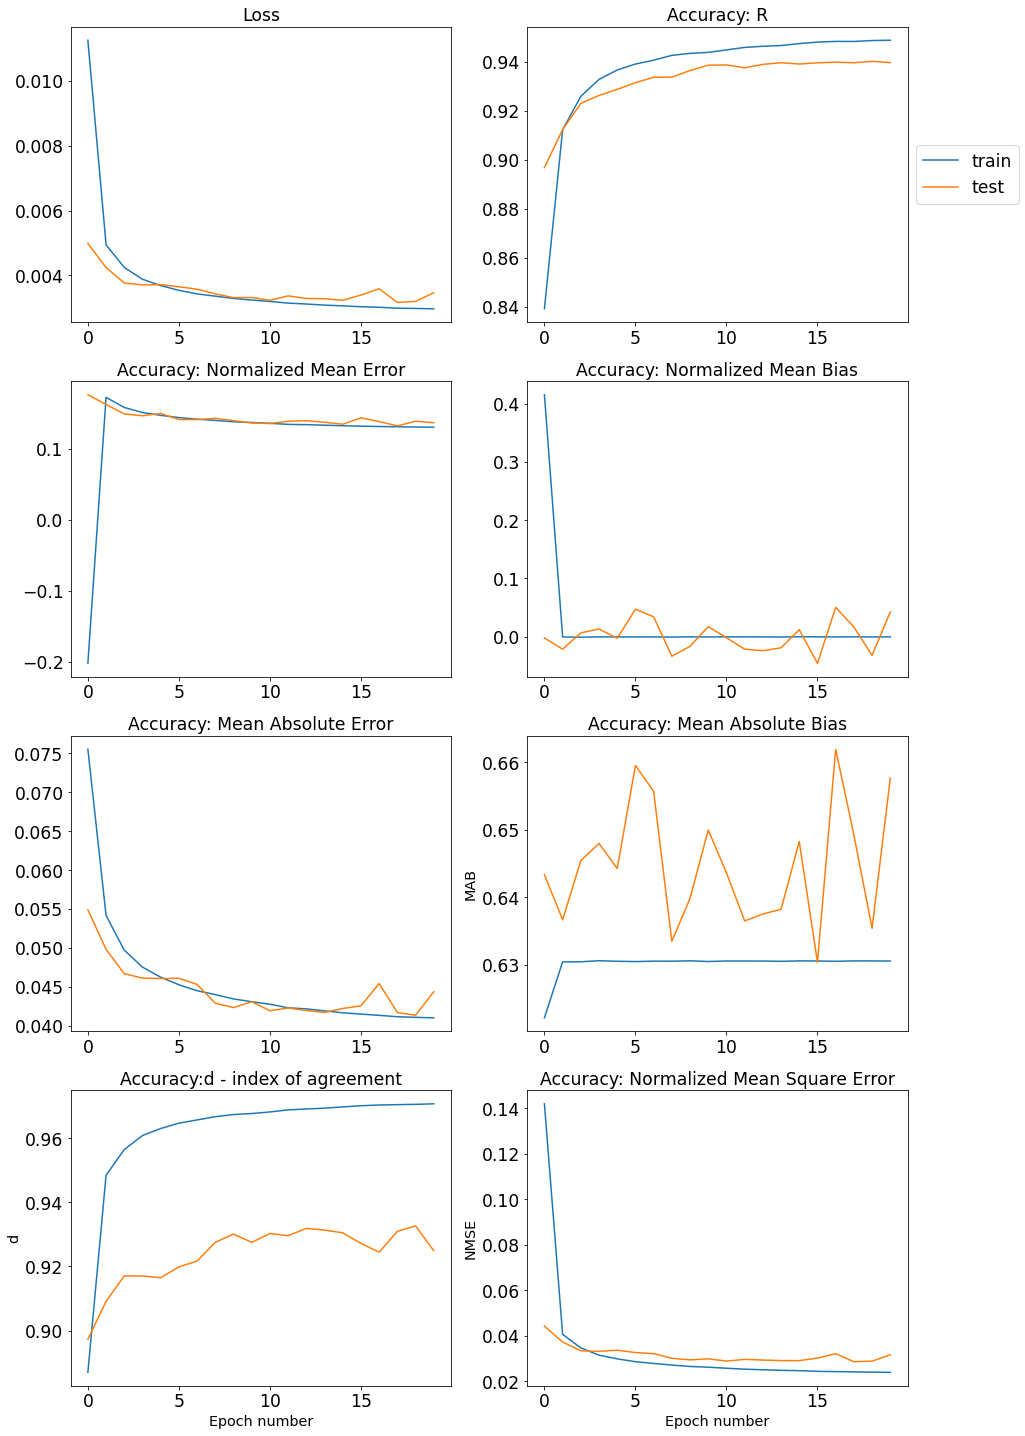

In [64]:
plot_training_validation_specific_metrics(history4)

## Predict on Simi Valley

In [59]:
y_pred_for_LSTM = model_lstm_4.predict(X_test_for_CNN, verbose=0)

In [60]:
pickle_out = open("/content/gdrive/My Drive/ML Research/Training Time vs. Model Performance/lstm_simivalley_prediction.pickle","wb")
pickle.dump(y_pred_for_LSTM, pickle_out)
pickle_out.close()

# pickle_in = open("/content/gdrive/My Drive/ML Research/Training Time vs. Model Performance/lstm_simivalley_prediction.pickle","rb")
# y_pred_for_LSTM = pickle.load(pickle_in)

In [61]:
y_pred_for_LSTM

array([[0.08033305],
       [0.07570097],
       [0.09561945],
       ...,
       [0.08880234],
       [0.0536351 ],
       [0.04658962]], dtype=float32)

In [62]:
y_pred_for_LSTM_rs = y_pred_for_LSTM.reshape((len(y_pred_for_LSTM),))

df_LA_LSTM = pd.DataFrame({
    'observed ozone': y_test_for_CNN*(SVC_df['Ozone'].max()-SVC_df['Ozone'].min())+SVC_df['Ozone'].min(),
    'LSTM simulated ozone': y_pred_for_LSTM_rs*(SVC_df['Ozone'].max()-SVC_df['Ozone'].min())+SVC_df['Ozone'].min(),
    'datetime': date_time_test_CNN,
    'hour of day': date_time_test_CNN.hour,
    'season': date_time_test_CNN.month%12 // 3 + 1 
})

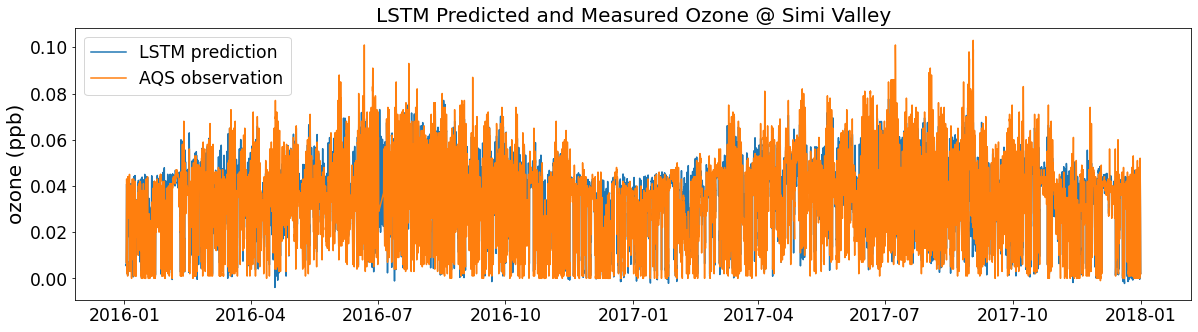

In [63]:
f, ax = plt.subplots(figsize=(20,5))
ax.plot(df_LA_LSTM['datetime'], df_LA_LSTM['LSTM simulated ozone'], label="LSTM prediction")
ax.plot(df_LA_LSTM['datetime'], df_LA_LSTM['observed ozone'], label="AQS observation")
ax.set_ylabel('ozone (ppb)',size=20)
ax.legend()
ax.set_title('LSTM Predicted and Measured Ozone @ Simi Valley', fontsize=20)
plt.show()

Now to figure out how to plot over one week!!!

In [65]:
df_week_LSTM = pd.DataFrame({
    'observed ozone': df_LA_LSTM['observed ozone'][:48],
    'simulated ozone': df_LA_LSTM['LSTM simulated ozone'][:48],
    'datetime': date_time_test_CNN[:48],
    'hour of day': date_time_test_CNN.hour[:48],
    'season': (date_time_test_CNN.month%12 // 3 + 1)[:48]
})

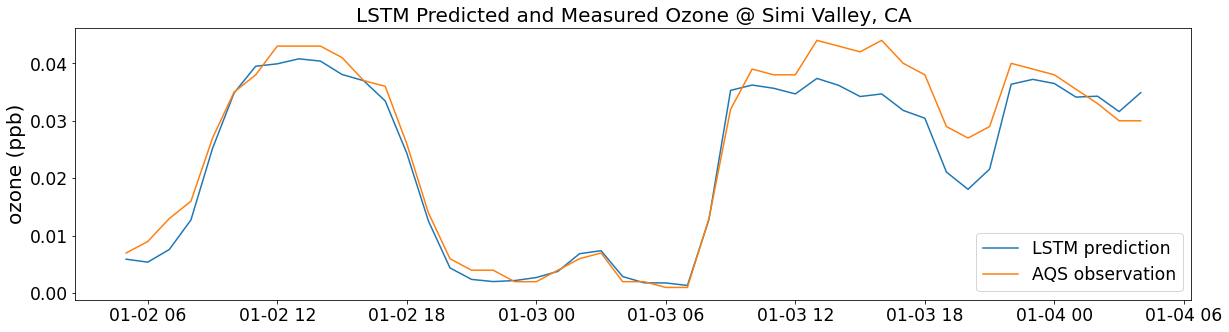

In [66]:
f, ax = plt.subplots(figsize=(20,5))
ax.plot(df_week_LSTM['datetime'], df_week_LSTM['simulated ozone'], label="LSTM prediction")
ax.plot(df_week_LSTM['datetime'], df_week_LSTM['observed ozone'], label="AQS observation")
ax.set_ylabel('ozone (ppb)',size=20)
ax.legend()
ax.set_title('LSTM Predicted and Measured Ozone @ Simi Valley, CA', fontsize=20)
plt.show()

In [68]:
df_week_LSTM = pd.DataFrame({
    'observed ozone': df_LA_LSTM['observed ozone'][:250],
    'simulated ozone': df_LA_LSTM['LSTM simulated ozone'][:250],
    'datetime': date_time_test_CNN[:250],
    'hour of day': date_time_test_CNN.hour[:250],
    'season': (date_time_test_CNN.month%12 // 3 + 1)[:250]
})

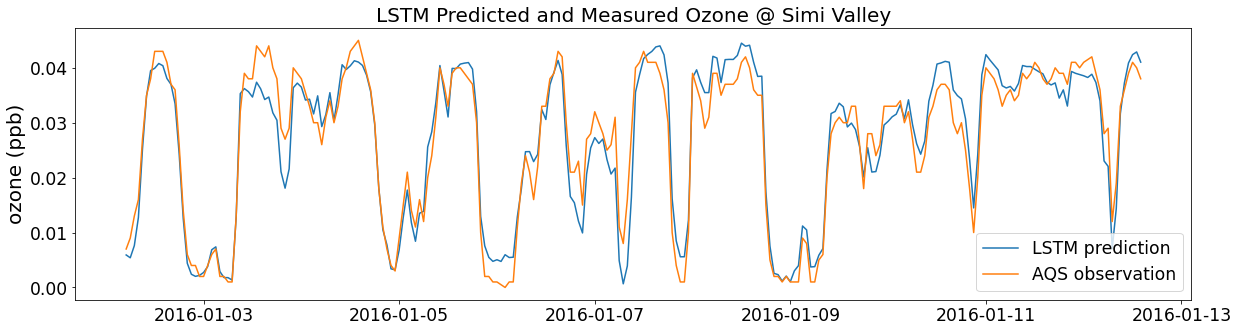

In [69]:
f, ax = plt.subplots(figsize=(20,5))
ax.plot(df_week_LSTM['datetime'], df_week_LSTM['simulated ozone'], label="LSTM prediction")
ax.plot(df_week_LSTM['datetime'], df_week_LSTM['observed ozone'], label="AQS observation")
ax.set_ylabel('ozone (ppb)',size=20)
ax.legend()
ax.set_title('LSTM Predicted and Measured Ozone @ Simi Valley', fontsize=20)
plt.show()

## Predict on Pump Yard

We import the data and split it the same

In [70]:
pickle_in = open("/content/gdrive/My Drive/ML Research/Training Time vs. Model Performance/CaMaderaPumpYard_df_2011_2017.pickle","rb")
CM_df = pickle.load(pickle_in)

In [71]:
CM_df

,Carbon monoxide,Nitrogen dioxide (NO2),Ozone,Wind Direction - Resultant,Wind Speed - Resultant,Outdoor Temperature,Relative Humidity,Solar radiation,Barometric pressure,Carbon monoxide - qualifier,Nitrogen dioxide (NO2) - qualifier,Ozone - qualifier,Wind Direction - Resultant - qualifier,Wind Speed - Resultant - qualifier,Outdoor Temperature - qualifier,Relative Humidity - qualifier,Solar radiation - qualifier,Barometric pressure - qualifier
datetime,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,NaN,15.0,0.008,101.0,5.2,40.0,77.0,0.0,1010.6,None,None,None,None,None,None,None,None,None
2011-01-01 01:00:00,NaN,10.0,0.015,108.0,4.3,41.0,73.0,0.0,1010.6,None,None,None,None,None,None,None,None,None
2011-01-01 02:00:00,NaN,8.0,0.021,112.0,6.1,42.0,69.0,0.0,1010.6,None,None,None,None,None,None,None,None,None
2011-01-01 03:00:00,NaN,NaN,NaN,122.0,6.9,43.0,65.0,0.0,1010.6,None,AX - Precision Check.,AX - Precision Check.,None,None,None,None,None,None
2011-01-01 04:00:00,NaN,NaN,NaN,120.0,8.7,44.0,62.0,0.0,1009.2,None,BD - Auto Calibration.,BD - Auto Calibration.,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 19:00:00,0.3,9.0,0.032,295.2,3.5,53.0,75.0,0.0,1009.1,None,None,None,None,None,None,None,None,None
2017-12-31 20:00:00,0.3,9.5,0.028,299.1,2.4,51.0,78.0,0.0,1009.5,None,None,None,None,None,None,None,None,None
2017-12-31 21:00:00,0.3,9.4,0.023,294.4,4.3,50.0,84.0,0.0,1009.8,None,None,None,None,None,None,None,None,None


In [72]:
CM_df = CM_df.drop(CM_df.columns[[8,9,10,11,12,13,14,15,16,17]], axis=1)
# CM_df = CM_df.drop('PM2.5 - Local Conditions', axis=1)
CM_df = CM_df.drop('Carbon monoxide', axis=1)
# CM_df = CM_df.drop('Barometric Pressure', axis=1)
CM_df

,Nitrogen dioxide (NO2),Ozone,Wind Direction - Resultant,Wind Speed - Resultant,Outdoor Temperature,Relative Humidity,Solar radiation
datetime,,,,,,,
2011-01-01 00:00:00,15.0,0.008,101.0,5.2,40.0,77.0,0.0
2011-01-01 01:00:00,10.0,0.015,108.0,4.3,41.0,73.0,0.0
2011-01-01 02:00:00,8.0,0.021,112.0,6.1,42.0,69.0,0.0
2011-01-01 03:00:00,NaN,NaN,122.0,6.9,43.0,65.0,0.0
2011-01-01 04:00:00,NaN,NaN,120.0,8.7,44.0,62.0,0.0
...,...,...,...,...,...,...,...
2017-12-31 19:00:00,9.0,0.032,295.2,3.5,53.0,75.0,0.0
2017-12-31 20:00:00,9.5,0.028,299.1,2.4,51.0,78.0,0.0
2017-12-31 21:00:00,9.4,0.023,294.4,4.3,50.0,84.0,0.0


Same NaN filling as before

In [73]:
CM_df = CM_df.interpolate()
CM_df.isna().sum()

Nitrogen dioxide (NO2)        0
Ozone                         0
Wind Direction - Resultant    0
Wind Speed - Resultant        0
Outdoor Temperature           0
Relative Humidity             0
Solar radiation               0
dtype: int64

In [74]:
# normalize!

n_steps = 24
CM_df_norm=(CM_df-CM_df.min())/(CM_df.max()-CM_df.min())

# switching the location of the columns
B = CM_df_norm.filter(['Ozone']) # just ozone
A = CM_df_norm.drop(['Ozone'], axis=1) # everything but ozone
C = pd.merge(A, B, left_index=True, right_index=True) # everything but ozone + just ozone
CM_df_np = C.to_numpy() # now in numpy format 

In [75]:
X_CM, y_CM = split_data(CM_df_np, n_steps)

In [76]:
print(len(CM_df))
print(len(X_CM))

61368
61345


Ok so this really is the same size!!

In [77]:
# takes first 3rd of data for test 
seventh = len(CM_df)//7
X_train_CM = X_CM[:seventh*5]
y_train_CM = y_CM[:seventh*5]
X_test_CM = X_CM[seventh*5:]
y_test_CM = y_CM[seventh*5:]

In [78]:
pickle_out = open("/content/gdrive/My Drive/ML Research/Training Time vs. Model Performance/y_test_CM.pickle","wb")
pickle.dump(y_test_CM, pickle_out)
pickle_out.close()

# pickle_in = open("/content/gdrive/My Drive/ML Research/Training Time vs. Model Performance/y_test_CM.pickle","rb")
# y_test_CM = pickle.load(pickle_in)

In [79]:
CM_df[seventh*5:]

,Nitrogen dioxide (NO2),Ozone,Wind Direction - Resultant,Wind Speed - Resultant,Outdoor Temperature,Relative Humidity,Solar radiation
datetime,,,,,,,
2016-01-01 06:00:00,4.152595,0.003,332.8,2.1,30.0,97.0,0.00
2016-01-01 07:00:00,4.153460,0.003,336.2,1.3,29.0,96.0,0.03
2016-01-01 08:00:00,4.154325,0.005,6.2,1.2,30.0,98.0,0.14
2016-01-01 09:00:00,4.155190,0.009,97.0,1.6,34.0,99.0,0.38
2016-01-01 10:00:00,4.156055,0.013,231.9,2.3,40.0,92.0,0.53
...,...,...,...,...,...,...,...
2017-12-31 19:00:00,9.000000,0.032,295.2,3.5,53.0,75.0,0.00
2017-12-31 20:00:00,9.500000,0.028,299.1,2.4,51.0,78.0,0.00
2017-12-31 21:00:00,9.400000,0.023,294.4,4.3,50.0,84.0,0.00


In [80]:
# the timestamp is shifted by a day (when n_steps = 24) because of how I set up the windowing
date_time_test_CM = C.index[seventh*5 + n_steps - 1:] 

In [81]:
pickle_out = open("/content/gdrive/My Drive/ML Research/Training Time vs. Model Performance/date_time_test_CM.pickle","wb")
pickle.dump(date_time_test_CM, pickle_out)
pickle_out.close()

Now testing!!

Build model

In [82]:
model_lstm_CM = Sequential()
model_lstm_CM.add(LSTM(8, input_shape=(n_steps, CM_df.shape[1]-1)))
model_lstm_CM.add(Dense(1))
model_lstm_CM.compile(loss='mean_squared_error', optimizer='adam', metrics=[metrics.mean_squared_error])
history4 = model_lstm_CM.fit(X_train_CM, y_train_CM, epochs=20, validation_split=0.2, batch_size=32, verbose=2)

Epoch 1/20
1096/1096 - 6s - loss: 0.0090 - mean_squared_error: 0.0090 - val_loss: 0.0054 - val_mean_squared_error: 0.0054 - 6s/epoch - 6ms/step
Epoch 2/20
1096/1096 - 4s - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0046 - val_mean_squared_error: 0.0046 - 4s/epoch - 4ms/step
Epoch 3/20
1096/1096 - 4s - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0044 - val_mean_squared_error: 0.0044 - 4s/epoch - 4ms/step
Epoch 4/20
1096/1096 - 4s - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0043 - val_mean_squared_error: 0.0043 - 4s/epoch - 4ms/step
Epoch 5/20
1096/1096 - 4s - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0043 - val_mean_squared_error: 0.0043 - 4s/epoch - 4ms/step
Epoch 6/20
1096/1096 - 4s - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0042 - val_mean_squared_error: 0.0042 - 4s/epoch - 4ms/step
Epoch 7/20
1096/1096 - 4s - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0040 - val_mean_squared_error: 0.0040 - 4s/epoch - 4

In [83]:
y_pred_LSTM_CM = model_lstm_CM.predict(X_test_CM, verbose=0)

In [84]:
pickle_out = open("/content/gdrive/My Drive/ML Research/Training Time vs. Model Performance/lstm_CM_prediction.pickle","wb")
pickle.dump(y_pred_LSTM_CM, pickle_out)
pickle_out.close()

In [85]:
y_pred_LSTM_CM_rs = y_pred_LSTM_CM.reshape((len(y_pred_LSTM_CM),))

df_LA_LSTM = pd.DataFrame({
    'observed ozone': y_test_CM*(CM_df['Ozone'].max()-CM_df['Ozone'].min())+CM_df['Ozone'].min(),
    'LSTM simulated ozone': y_pred_LSTM_CM_rs*(CM_df['Ozone'].max()-CM_df['Ozone'].min())+CM_df['Ozone'].min(),
    'datetime': date_time_test_CM,
    'hour of day': date_time_test_CM.hour,
    'season': date_time_test_CM.month%12 // 3 + 1 
})

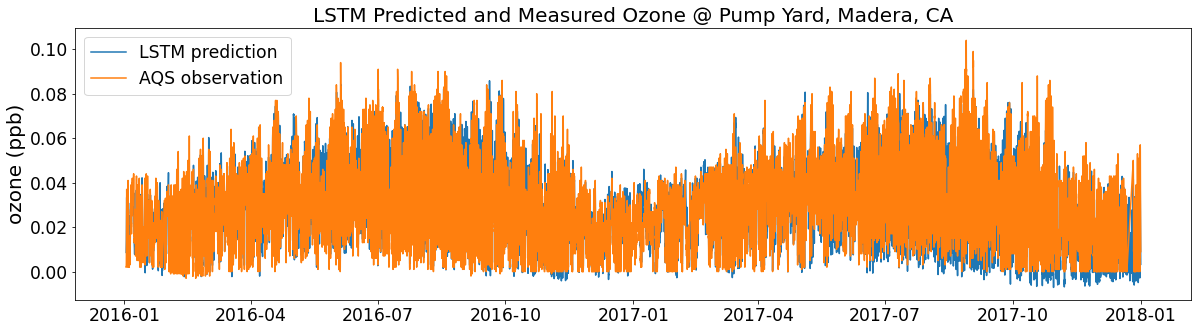

In [86]:
f, ax = plt.subplots(figsize=(20,5))
ax.plot(df_LA_LSTM['datetime'], df_LA_LSTM['LSTM simulated ozone'], label="LSTM prediction")
ax.plot(df_LA_LSTM['datetime'], df_LA_LSTM['observed ozone'], label="AQS observation")
ax.set_ylabel('ozone (ppb)',size=20)
ax.legend()
ax.set_title('LSTM Predicted and Measured Ozone @ Pump Yard, Madera, CA', fontsize=20)
plt.show()

In [87]:
df_week_LSTM = pd.DataFrame({
    'observed ozone': df_LA_LSTM['observed ozone'][:250],
    'simulated ozone': df_LA_LSTM['LSTM simulated ozone'][:250],
    'datetime': date_time_test_CM[:250],
    'hour of day': date_time_test_CM.hour[:250],
    'season': (date_time_test_CM.month%12 // 3 + 1)[:250]
})

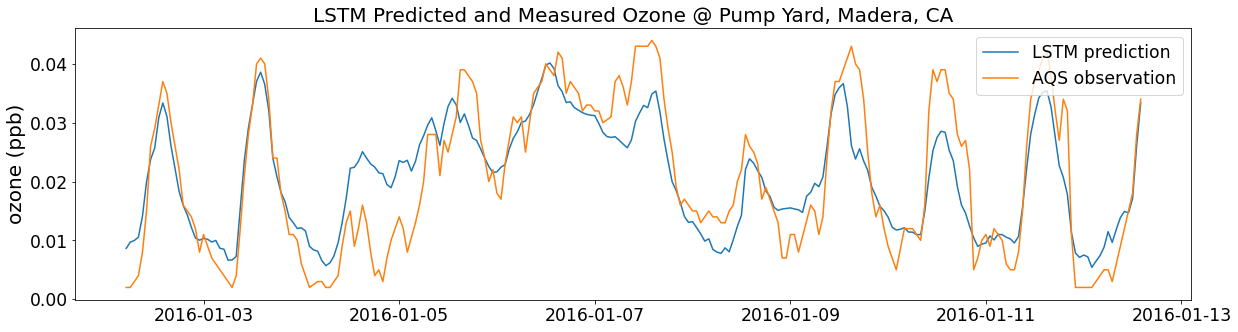

In [89]:
f, ax = plt.subplots(figsize=(20,5))
ax.plot(df_week_LSTM['datetime'], df_week_LSTM['simulated ozone'], label="LSTM prediction")
ax.plot(df_week_LSTM['datetime'], df_week_LSTM['observed ozone'], label="AQS observation")
ax.set_ylabel('ozone (ppb)',size=20)
ax.legend()
ax.set_title('LSTM Predicted and Measured Ozone @ Pump Yard, Madera, CA', fontsize=20)
plt.show()